# Data Cleaning Challenge

Open access journals are free to the readers but often charge high ["open access fees"](https://www.nature.com/news/open-access-the-true-cost-of-science-publishing-1.12676) to the researchers. The Welcome Trust helped many researchers pay for their fees and released the spend data in 2012-2013. From this dataset, we can answer the following questions:

- What are the top 5 journals that the Welcome Trust helped pay for? How many articles were published in each?
- For each journal, what are the mean, the median, and the standard deviation of the open-access fee per article?

## Import data

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

Directly reading Welcome Trust's data file (`df = pd.read_csv('journals.csv')`) returns a `UnicodeDecodeError `, suggesting that their file isn't encoded by unicode. We can use `chardet` to detect the most likely encoding method and decode accordingly.

In [208]:
# Use chardet to detect encoding 
with open("journals.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# View the result    
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


Interestingly, chardet makes different guesses depending on how many characters we let it read. When the number is small (< 100), the most likely guess is ascii. When the number is between 100 and 10000, the best guess is ISO-8859-1. At 100000 characters, the best guess becomes Windows-1252. Among the three encoding methods, only ISO-8859-1 can successfully decode the file.

In [209]:
# Use the most likely encoding method to decode
charenc = result['encoding']
df = pd.read_csv('journals.csv', encoding=charenc)

In [210]:
# Check first 5 rows
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


The column names are quite verbose; let's rename them into something simpler.

In [211]:
newcols = {
    df.columns[0]: 'pmcid',
    df.columns[1]: 'publisher', 
    df.columns[2]: 'journal',
    df.columns[3]: 'article',
    df.columns[4]: 'cost'
    }

df = df.rename(columns=newcols)

In [212]:
# Take a look again
df.head()

,pmcid,publisher,journal,article,cost
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


## Check for duplicates
One column that shouldn't have duplicates is `article`. We can use `.describe()` to quickly check.

In [213]:
df.describe()

,pmcid,publisher,journal,article,cost
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,Not yet available,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


Since the unique count of articles is 1 fewer than the count, there is one duplicate. We can keep the first record.

In [214]:
df.drop_duplicates(subset=['article'], keep='first', inplace=True)

## Top 5 journals
If journal names were entered properly, we can do a quick value count by journal and find out what the top 5 are. Unfortunately, the names seem quite messy.

In [215]:
df['journal'].value_counts().head(30)

PLoS One                                           91
PLoS ONE                                           62
Journal of Biological Chemistry                    48
Nucleic Acids Research                             21
Proceedings of the National Academy of Sciences    19
Human Molecular Genetics                           18
PLoS Neglected Tropical Diseases                   18
Nature Communications                              17
PLoS Genetics                                      15
Neuroimage                                         15
PLoS Pathogens                                     15
PLOS ONE                                           14
BMC Public Health                                  14
NeuroImage                                         14
Brain                                              14
Movement Disorders                                 13
Developmental Cell                                 12
Biochemical Journal                                12
Journal of Neuroscience     

For instance, _PLOS One_ has several synonyms due to different capitalization styles, such as "_PloS One_", "_PloS ONE_", etc.. For simplicity, we can use the `.title()` method to capitalize the first letter of each word in all journal titles. Stylistically, this isn't the most ideal choice since, for example, _PNAS_ will become _Pnas_. However, this is good enough for counting.

In [216]:
df['journal'] = df['journal'].apply(lambda x: str(x).title())

Although I didn't spot weird spacings in the (abridged) list above, it's still safer that we remove all potential empty spaces using the `.strip()` method.

In [217]:
df['journal'] = df['journal'].apply(lambda x: str(x).strip())

It's trickier to deal with synonyms caused by abbreviations, omissions, typos, etc.. For these cases, we can look through all journal names for anything suspicious. 

In [218]:
names = sorted(df['journal'].unique())
# print to see the full list: print(names)

After a quick look, I already saw several typos (e.g., *Epigenetics* vs. *Epigentics*), omissions (e.g., *Virology* vs. *Virology Journal*), different uses of symbols (*Health & Place* vs. *Health And Place*), different abbreviations (e.g., *PNAS* vs. *Proc Natl Acad Sci U S A*), and various other ways that led to synonyms. *PNAS* alone has quite a lot of variations, such as:

- Pnas
- Pnas (Proceedings Of The National Academy Of Sciences Of The United States Of America
- Pnas Usa
- Proc Natl Acad Sci U S A.
- Proceddings Of The National Academy Of Sciences Of Usa
- Proceedings Of The National Academy Of Sciences
- Proceedings Of The National Academy Of Sciences (Pnas)
- Proceedings Of The National Academy Of Sciences Of The United States Of America
- Proceedings Of The National Academy Of Sciences Of The Usa
- ... 

There may not be a one-size-fit-all solution to all problems and each has to be dealt with on a case by case basis. It's easy to fix using "&" instead of "And".

In [219]:
df['journal'] = df['journal'].apply(lambda x: str(x).replace('&', 'And'))

Other issues may require more advanced methods to solve. Since we are only looking for the top 5 journals, we may not need clean everything. After a quick look below, among journals that have messy names, only PNAS seems like it could make it to top 5. For our immediate purpose, we can just pick out PNAS to clean.

In [220]:
df['journal'].value_counts().head(10)

Plos One                                           189
Journal Of Biological Chemistry                     53
Neuroimage                                          29
Nucleic Acids Research                              26
Plos Genetics                                       24
Plos Pathogens                                      24
Proceedings Of The National Academy Of Sciences     22
Plos Neglected Tropical Diseases                    20
Nature Communications                               19
Human Molecular Genetics                            19
Name: journal, dtype: int64

In [221]:
# Substrings contained in different synonyms of PNAS
pnas = ['Proceedings Of The National Academy Of Sciences', 'Proc Natl Acad Sci', 'Pnas']

# is_pnas is True if journal names contain one of the substrings above  
df['is_pnas'] = df['journal'].apply(lambda x: any(i in str(x) for i in pnas))

# If is_pnas is True, replace journal names with "Proceedings Of The National Academy Of Sciences"
df.loc[df['is_pnas'] == True, ['journal']] = 'Proceedings Of The National Academy Of Sciences'

The table below shows the five most common journals that the Welcome Trust helped pay for during 2012-2013 as well and the number articles published in each journal. 
With variations of names taken care of, PNAS has now made it to the top 3 (rather than top 7 previously)!

In [222]:
df['journal'].value_counts().head(5)

Plos One                                           189
Journal Of Biological Chemistry                     53
Proceedings Of The National Academy Of Sciences     36
Neuroimage                                          29
Nucleic Acids Research                              26
Name: journal, dtype: int64

## Open-access fee per article
Before calculating each journal's mean and median open-access fees per article and the standard deviation, we need to first make sure that all costs are numeric.

In [223]:
# Remove all "£"
df['cost'] = df['cost'].apply(lambda x: str(x).replace('£', ''))

# Convert to numerics
df['cost'] = pd.to_numeric(df['cost'], errors='coerce')

Now we can generate a brief description of the cost data. 

In [224]:
df['cost'].describe()

count      2113.000000
mean      24217.507089
std      147334.981612
min           0.000000
25%        1280.000000
50%        1890.000000
75%        2322.570000
max      999999.000000
Name: cost, dtype: float64

Obviously, no journal can charge £999,999 for open access publishing; this number most likely used to code missing values. 

In [226]:
# Replace 999999.000000 with null values
df.loc[df['cost'] == 999999.000000, ['cost']] = None

# Look at the description
df['cost'].describe()

count      2066.000000
mean       2019.186583
std        6120.799331
min           0.000000
25%        1269.740000
50%        1863.930000
75%        2304.022500
max      201024.000000
Name: cost, dtype: float64

The new maximum cost £201,024 still seems to high, which is quite likely a typo. We can use `.clip()` to replace extreme values with more reasonable boundary values.

In [227]:
# Set boundary values to the 0.01 and 0.09 quantiles
df['cost'] = df['cost'].clip(lower=df['cost'].quantile(0.01), upper=df['cost'].quantile(0.99))

Below is the probability distribution of open access fees after cleaning.

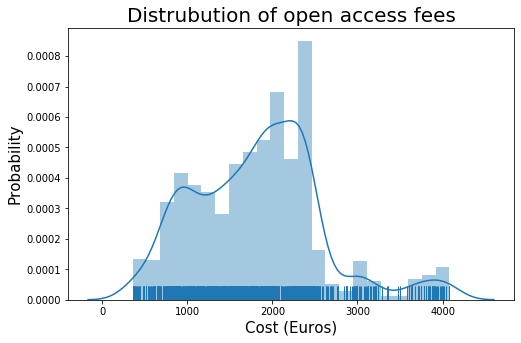

In [228]:
plt.figure(figsize=(8, 5))
ax = sns.distplot(df['cost'].dropna(), rug=True)
plt.xlabel('Cost (Euros)', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.title('Distrubution of open access fees', fontsize = 20)
plt.show()

In [250]:
# Summary of costs, except for medians
all_but_medians = df.groupby('journal')['cost'].describe()
all_but_medians = all_but_medians[['mean', 'std']]

# Median costs
medians = df.groupby('journal')['cost'].median()

# Concatenate the two dataframes
summary = pd.concat([medians, all_but_medians.reindex(medians.index)], axis=1)
summary.rename(columns = {'cost': 'median'}, inplace = True) 

# Drop rows where no journal names nor standard deviations are provided
summary['journal'] = summary.index
summary.dropna(subset=['journal', 'std'], inplace=True)

# View the first few rows, sorted by mean from high to low
summary.sort_values(by=['mean'], ascending=False).head(10)

,median,mean,std,journal
journal,,,,
The Lancet,4079.96650,4079.966500,5.569495e-13,The Lancet
The Lancet Neurology,4079.96650,4079.966500,0.000000e+00,The Lancet Neurology
Cell Host And Microbe,3959.42325,3959.423250,1.704739e+02,Cell Host And Microbe
Immunity,3934.75000,3934.750000,1.907916e+02,Immunity
Cell Metabolism,3904.46000,3922.745500,1.489226e+02,Cell Metabolism
Molecular Cell,3906.43000,3902.928833,1.788140e+02,Molecular Cell
Structure,3895.64000,3879.538071,1.634876e+02,Structure
Cell Reports,3836.32000,3644.226667,3.697352e+02,Cell Reports
Neglected Tropical Disease,3600.00000,3600.000000,0.000000e+00,Neglected Tropical Disease
